In [35]:
#Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import numpy as np
from scipy import stats
from scipy.stats import chi2_contingency, pearsonr
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statannotations.Annotator import Annotator

In [36]:
df = pd.read_csv('cleansed_data.csv')

# Datas analysis

## Outliers identification

In [37]:
def mean(x):
    mean_list=[]
    std_list=[]
    for i in range(0, x.shape[1]):
        mu=x.iloc[:,i].mean()
        mean_list.append(mu)
        std=x.iloc[:,i].std()
        std_list.append(std)
        return mean_list, std_list
mean(df)

([np.float64(39.222139117427076)], [np.float64(14.044332734156425)])

In [38]:
#IQR ou InterQuantile Range
def find_iqr(x):
  return np.subtract(*np.percentile(x, [75, 25]))

#calculate IQR for 'continue' columns
df[['charges', 'children', 'bmi', 'age']].apply(find_iqr)


charges     11911.37345
children        2.00000
bmi             8.41000
age            24.00000
dtype: float64

In [39]:
def find_outliers_iqr(x):
    Q1 = np.percentile(x, 25)
    Q3 = np.percentile(x, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

columns = ['charges', 'children', 'bmi', 'age']

#List to collect outliers
all_outliers = []

for i in columns:
    lower_bound, upper_bound = find_outliers_iqr(df[i])
    outliers = df[i][(df[i] < lower_bound) | (df[i] > upper_bound)]
    all_outliers.append(outliers)
    print(f"Valeurs aberrantes pour la colonne {i} :")
    print(outliers)

#Combine all the outliers
all_outliers_combined = pd.concat(all_outliers)

#Count outliers
outliers_counts = all_outliers_combined.value_counts()
print("\nFréquences des valeurs aberrantes :")
print(outliers_counts)

Valeurs aberrantes pour la colonne charges :
14      39611.75770
19      36837.46700
23      37701.87680
29      38711.00000
30      35585.57600
           ...     
1299    62592.87309
1300    46718.16325
1302    37829.72420
1312    36397.57600
1322    43896.37630
Name: charges, Length: 139, dtype: float64
Valeurs aberrantes pour la colonne children :
Series([], Name: children, dtype: int64)
Valeurs aberrantes pour la colonne bmi :
116     49.06
286     48.07
401     47.52
543     47.41
846     50.38
859     47.60
1046    52.58
1087    47.74
1316    53.13
Name: bmi, dtype: float64
Valeurs aberrantes pour la colonne age :
Series([], Name: age, dtype: int64)

Fréquences des valeurs aberrantes :
39611.7577    1
36837.4670    1
37701.8768    1
38711.0000    1
35585.5760    1
             ..
50.3800       1
47.6000       1
52.5800       1
47.7400       1
53.1300       1
Name: count, Length: 148, dtype: int64


#### Identification of outlier by Z-score

<Axes: xlabel='z_charges', ylabel='Count'>

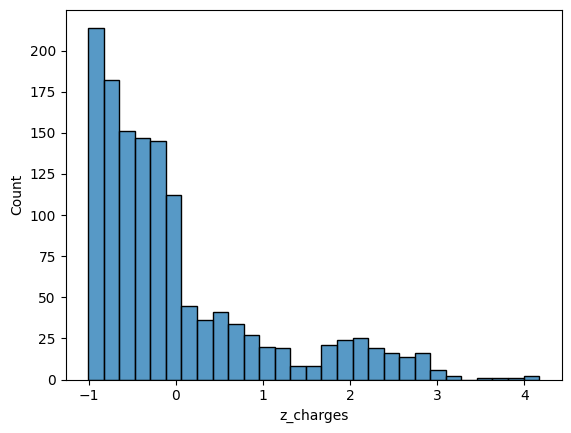

In [40]:
zscore =stats.zscore(df.charges)
zscore
df_zscore=pd.DataFrame(zscore, columns=['z_charges'])
df_zscore['z_age']=stats.zscore(df.age)
df_zscore['z_bmi']=stats.zscore(df.bmi)
df_zscore['z_children']=stats.zscore(df.children)
df_zscore
sns.histplot(x=df_zscore.z_charges)

All values with a score greater than Z=3 are outliers

Number of outliers for z_charges: 7
Number of outliers for z_age: 0
Number of outliers for z_bmi: 4
Number of outliers for z_children: 18


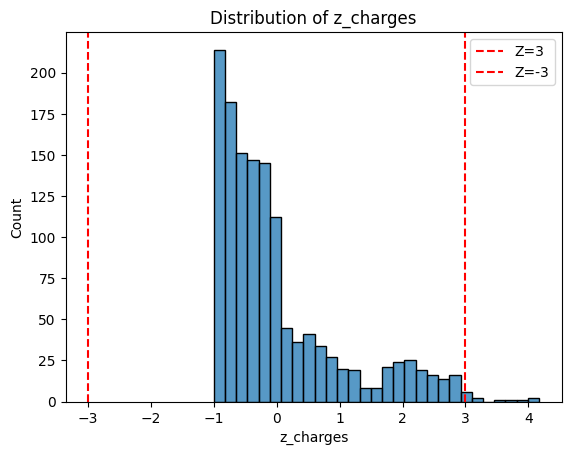

In [41]:
#Find outliers:
outliers = {}
for col in df_zscore.columns:
    outliers[col] = df_zscore[df_zscore[col] > 3]

#count oultier for each column:
outliers_count = {col: len(outliers[col]) for col in outliers}

#Result:
for col, count in outliers_count.items():
    print(f"Number of outliers for {col}: {count}")

#Visualization:
sns.histplot(x=df_zscore['z_charges'])
plt.axvline(3, color='red', linestyle='--', label='Z=3')
plt.axvline(-3, color='red', linestyle='--', label='Z=-3')
plt.legend()
plt.title('Distribution of z_charges')
plt.show()

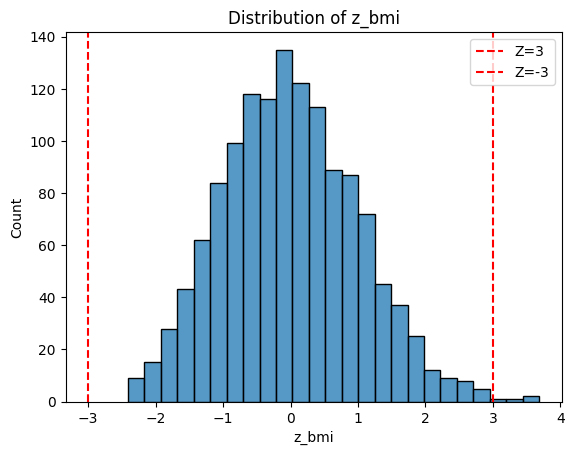

In [42]:
sns.histplot(x=df_zscore['z_bmi'])
plt.axvline(3, color='red', linestyle='--', label='Z=3')
plt.axvline(-3, color='red', linestyle='--', label='Z=-3')
plt.legend()
plt.title('Distribution of z_bmi')
plt.show()

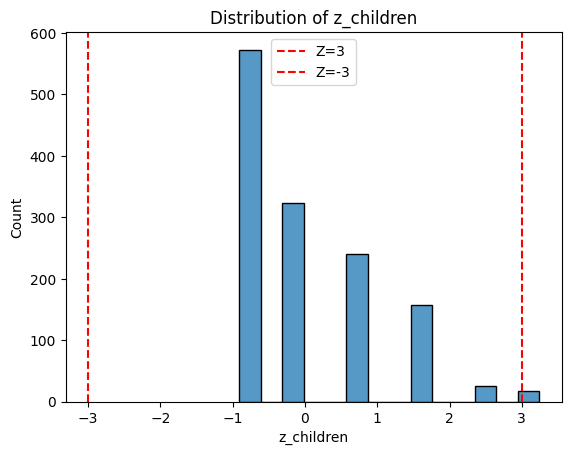

In [43]:
sns.histplot(x=df_zscore['z_children'])
plt.axvline(3, color='red', linestyle='--', label='Z=3')
plt.axvline(-3, color='red', linestyle='--', label='Z=-3')
plt.legend()
plt.title('Distribution of z_children')
plt.show()

²

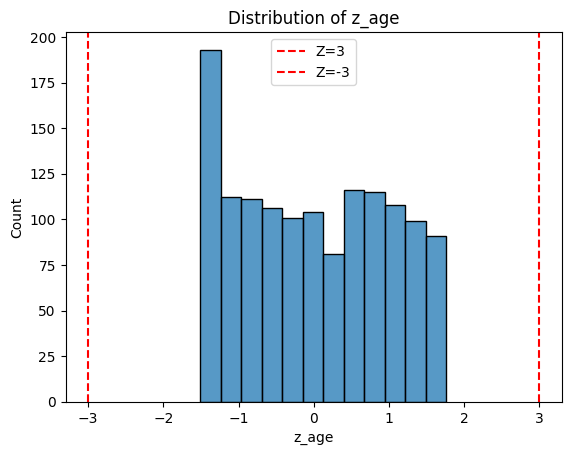

In [44]:
sns.histplot(x=df_zscore['z_age'])
plt.axvline(3, color='red', linestyle='--', label='Z=3')
plt.axvline(-3, color='red', linestyle='--', label='Z=-3')
plt.legend()
plt.title('Distribution of z_age')
plt.show()

## Univariate analysis

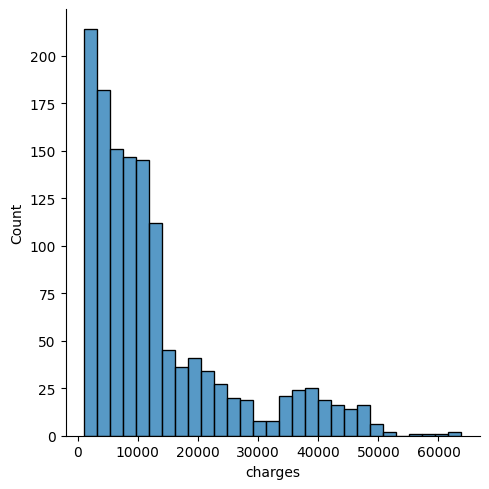

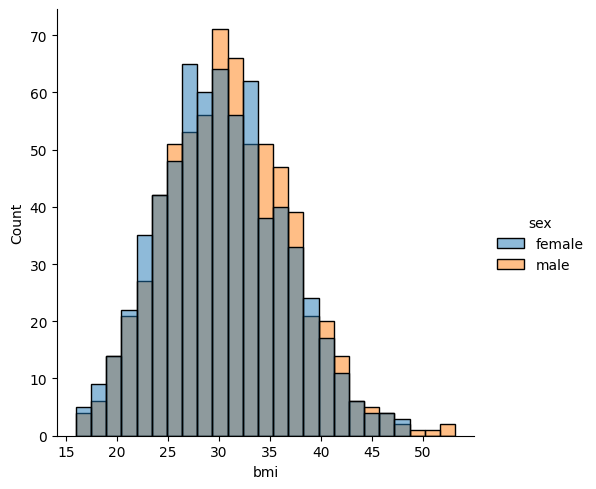

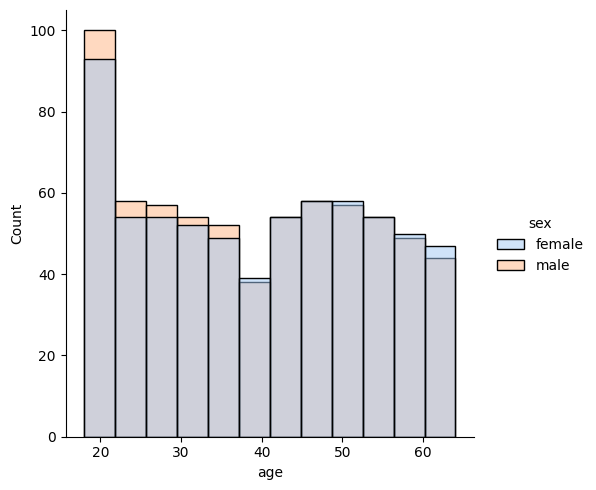

In [45]:
sns.displot(df, x="charges")
sns.displot(df, x="bmi", hue='sex')
sns.displot(df, x="age", hue='sex', palette='pastel')

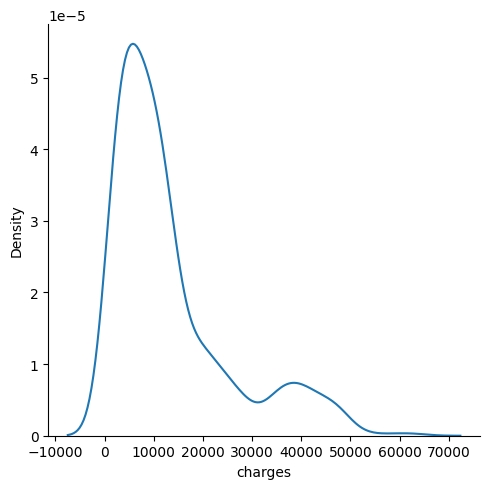

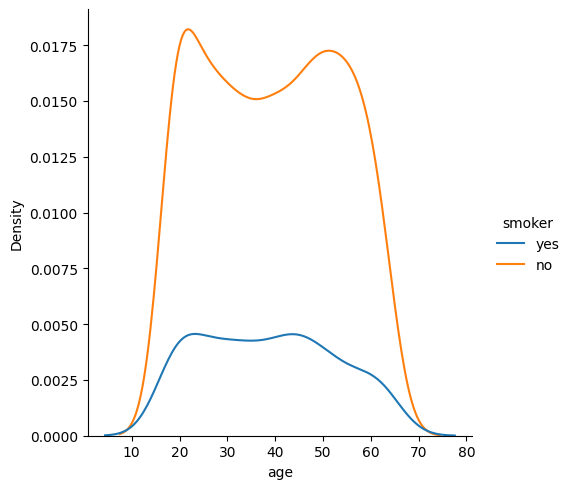

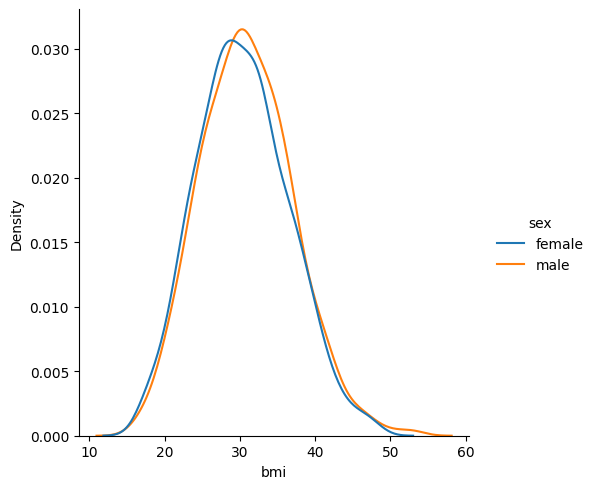

In [46]:
#Kernel density estimation
sns.displot(df, x="charges", kind="kde")
sns.displot(df,x="age", kind="kde", hue="smoker")
sns.displot(df, x="bmi", kind='kde', hue="sex")


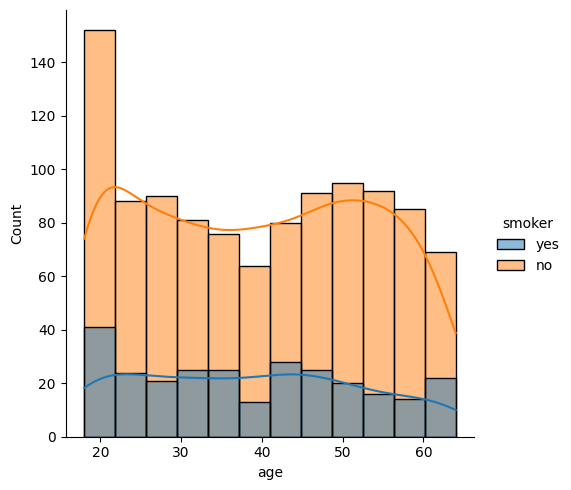

In [47]:
sns.displot(df,x="age", kde=True, hue="smoker")

### Study of the logarythme effect on value's distribution 

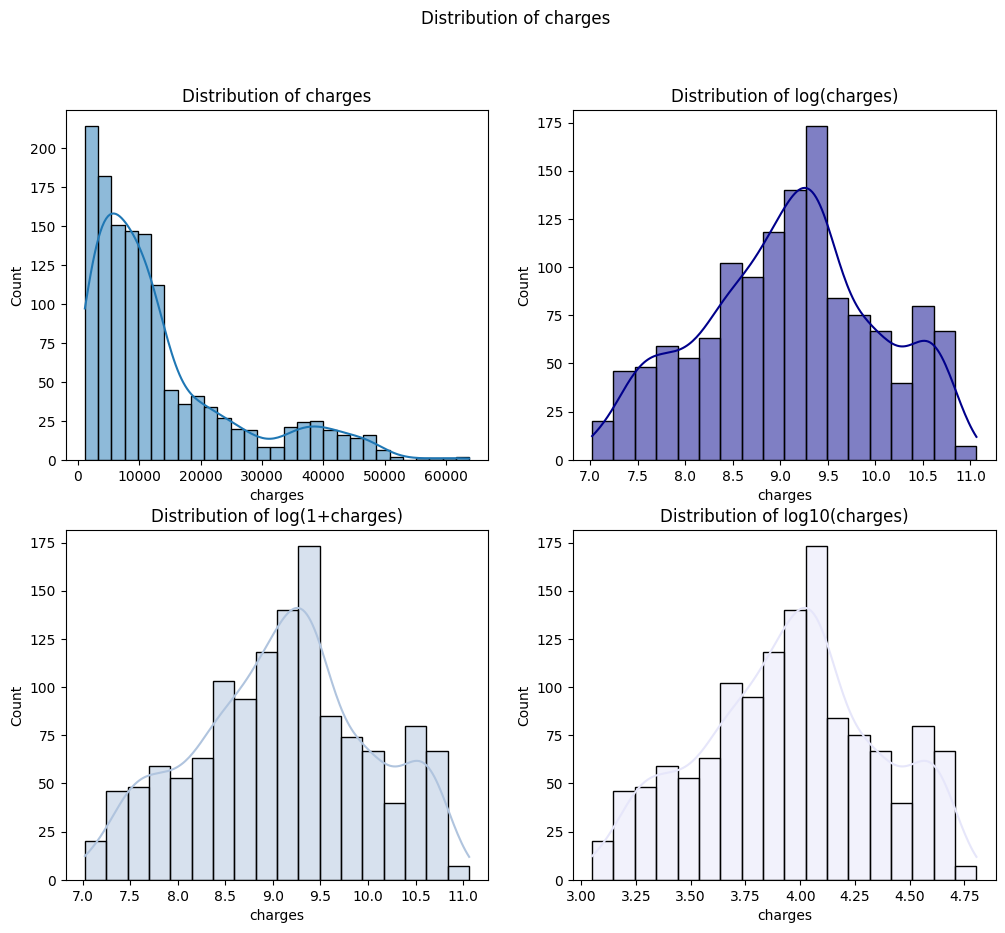

/home/ludivine/Documents/prime_assurance/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ludivine/Documents/prime_assurance/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


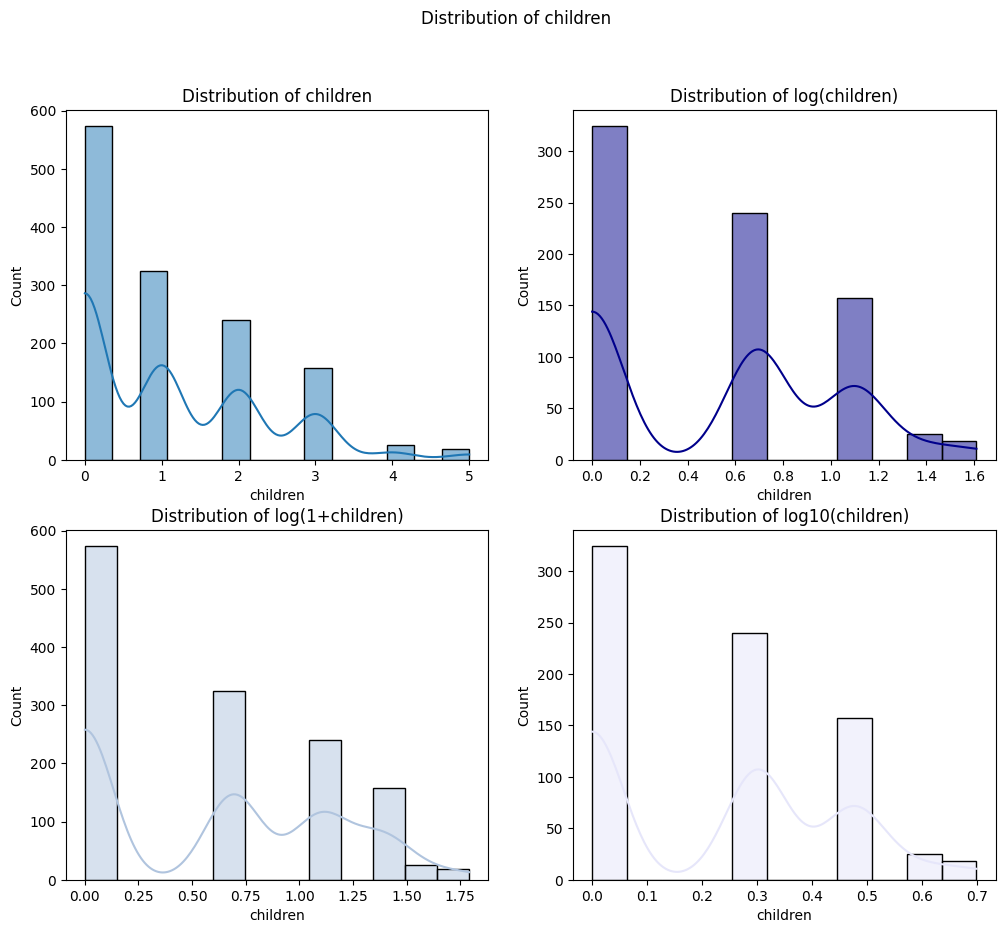

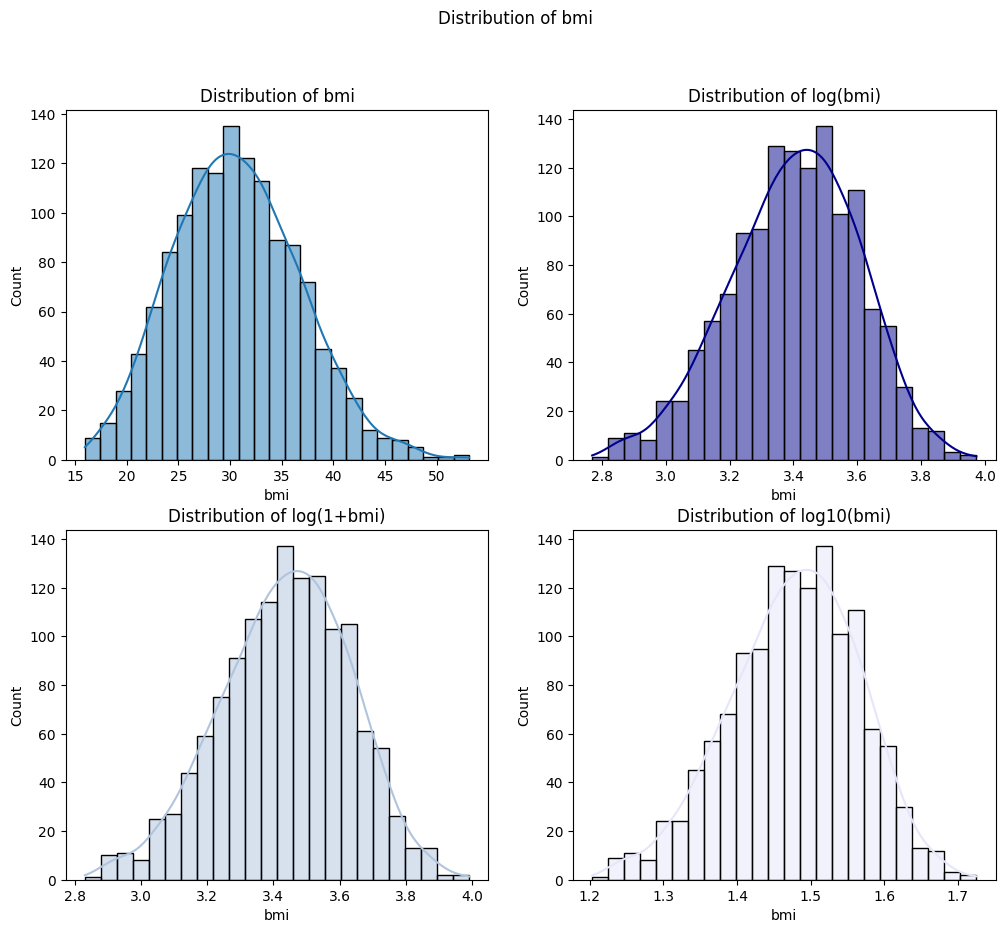

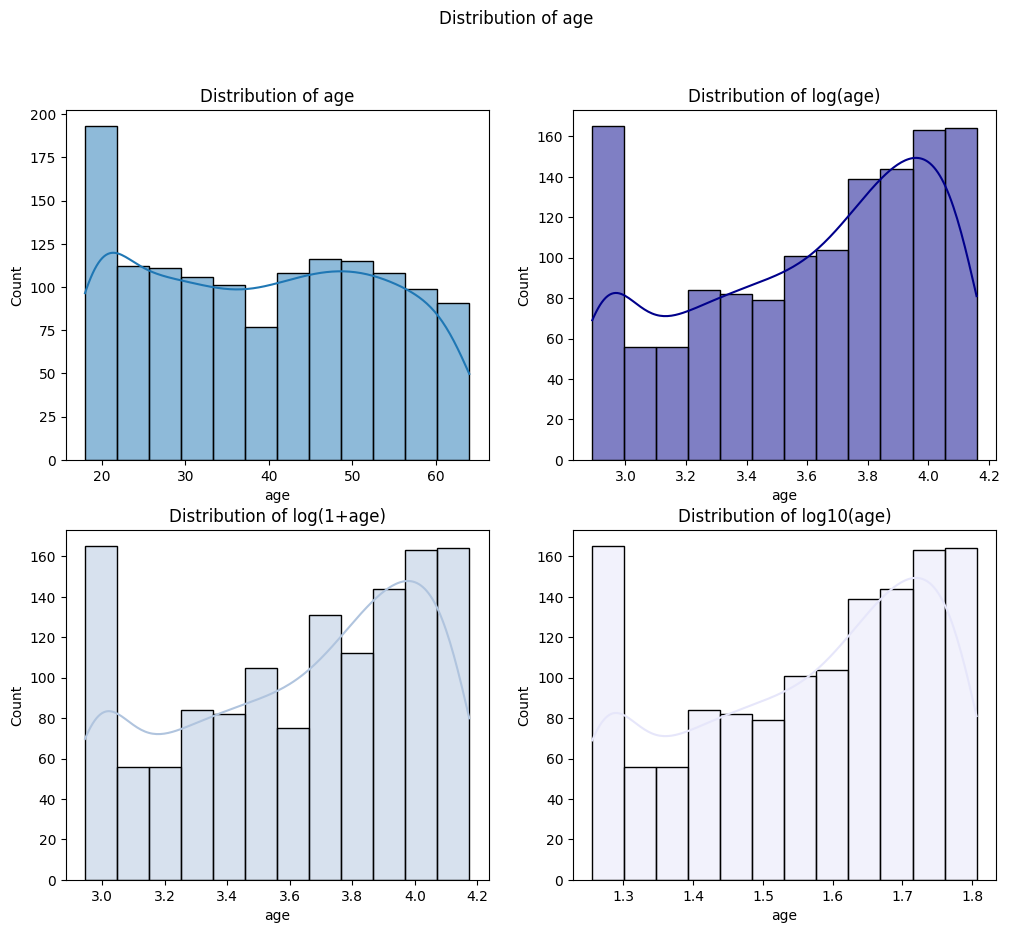

In [48]:
for i in columns:
    #Fig 2*2 sub-graph:
    fig, axes= plt.subplots(2,2, figsize=(12,10))
    fig.suptitle(f'Distribution of {i}')
    
    #Normal distribution
    sns.histplot(df[i], ax=axes[0,0], kde=True)
    axes[0,0].set_title(f'Distribution of {i}')

    #Return the natural logarithm of i, inverse of exp(i)
    log_data = np.log(df[i])
    sns.histplot(log_data,ax=axes[0,1], color='darkblue', kde=True)
    axes[0,1].set_title(f'Distribution of log({i})')

    #Return the natural logarithm of one plus the input array, element-wise.
    #the inverse of exp(x)-1
    log_1p = np.log1p(df[i])
    sns.histplot(log_1p, ax=axes[1,0], color='lightsteelblue', kde=True)
    axes[1,0].set_title(f'Distribution of log(1+{i})')

    #Return the base 10 log
    log_10 = np.log10(df[i])
    sns.histplot(log_10, ax=axes[1,1], color='lavender', kde=True)
    axes[1,1].set_title(f'Distribution of log10({i})')

    plt.show()

The analysis of the distribution of continuous variables allows us to see different points. The bmi distribution follows a normal distribution, unlike the other values. The log transformation result in more centered distribution, but nothing is magic! 
Is there any different ways to transform and test our datas ?  Let's check !

### Study of categorial values

In [49]:
# Frequency table
columns_cat = ['sex','smoker','region']

for i in columns_cat:
    count=df[i].value_counts()
    print("Frequency:")
    print(count)

Frequency:
sex
male      675
female    662
Name: count, dtype: int64
Frequency:
smoker
no     1063
yes     274
Name: count, dtype: int64
Frequency:
region
southeast    364
southwest    325
northwest    324
northeast    324
Name: count, dtype: int64


In [50]:
# Proportional frequency table
columns_cat = ['sex','smoker','region']

for i in columns_cat:
    count=df[i].value_counts(normalize=True)
    print("Fréquence:")
    print(count)

Fréquence:
sex
male      0.504862
female    0.495138
Name: proportion, dtype: float64
Fréquence:
smoker
no     0.795064
yes    0.204936
Name: proportion, dtype: float64
Fréquence:
region
southeast    0.272251
southwest    0.243082
northwest    0.242334
northeast    0.242334
Name: proportion, dtype: float64


Text(0.5, 1.0, 'Gender distribution')

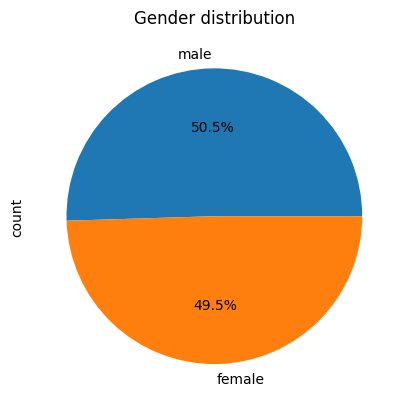

In [51]:
df['sex'].value_counts().plot(kind='pie', autopct='%1.1f%%').set_title(f'Gender distribution')

Text(0.5, 1.0, 'Smoker distribution')

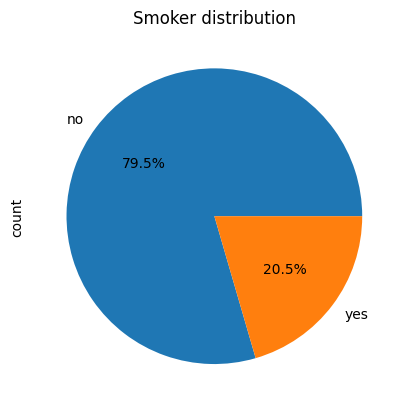

In [52]:
df['smoker'].value_counts().plot(kind='pie', autopct='%1.1f%%').set_title(f'Smoker distribution')

Text(0.5, 1.0, 'Regional distribution')

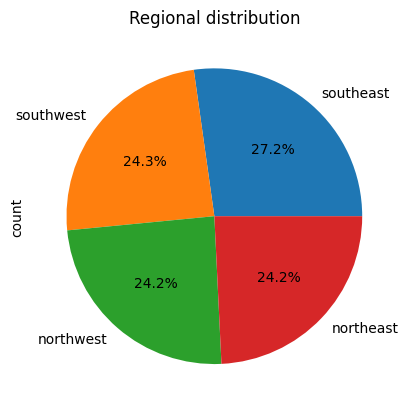

In [53]:
df['region'].value_counts().plot(kind='pie', autopct='%1.1f%%').set_title(f'Regional distribution')

The frequency tables allows us to visualize the distribution of datas between male and female, between smokers and non-smokers or between different regions. Gender and location repartition are balanced. A particular care will be given in the split operation in order to respect the proportion of smoker and non-smoker people in train et test sample.

# Bivariate analysis

#### Chi² test to check if there is a significative association between two categorical values

H0 = two variables are independant
H1 = two variables are dependant 

If p is less than 0.05, H0 is rejected.

In [54]:
#Test for sex and region
table_SR = pd.crosstab(df['sex'], df['region'])
chi2, p, dof, expected = chi2_contingency(table_SR)
print(f"Chi² : {chi2}, p-value : {p}, Degrees of Freedom : {dof}")
print(f"Expected numbers : \n{expected}")

Chi² : 0.476909551071918, p-value : 0.9239341965125791, Degrees of Freedom : 3
Expected numbers : 
[[160.42483171 160.42483171 180.23036649 160.91997008]
 [163.57516829 163.57516829 183.76963351 164.08002992]]


'sex' and 'region' variables are independant

In [55]:
#Test for 'sex' and 'smoker'
table_SSm = pd.crosstab(df['sex'], df['smoker'])
chi2, p, dof, expected = chi2_contingency(table_SSm)
print(f"Chi² : {chi2}, p-value : {p}, Degrees of Freedom : {dof}")
print(f"Expected numbers : \n{expected}")

Chi² : 7.469139330086637, p-value : 0.0062765550120107375, Degrees of Freedom : 1
Expected numbers : 
[[526.33208676 135.66791324]
 [536.66791324 138.33208676]]


These variables are dependant!

<Axes: xlabel='smoker', ylabel='sex'>

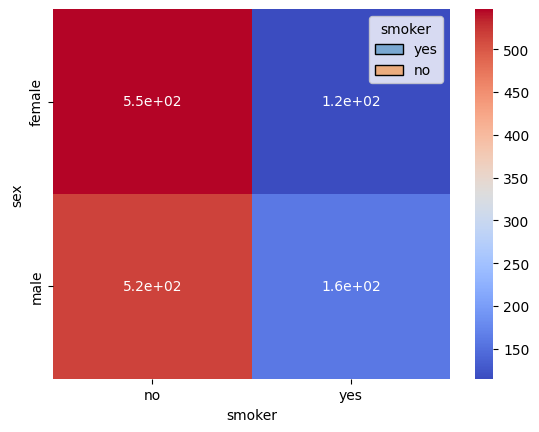

In [56]:
sns.histplot(data=df, x="sex", hue="smoker")
sns.heatmap(table_SSm, annot=True, cmap='coolwarm')

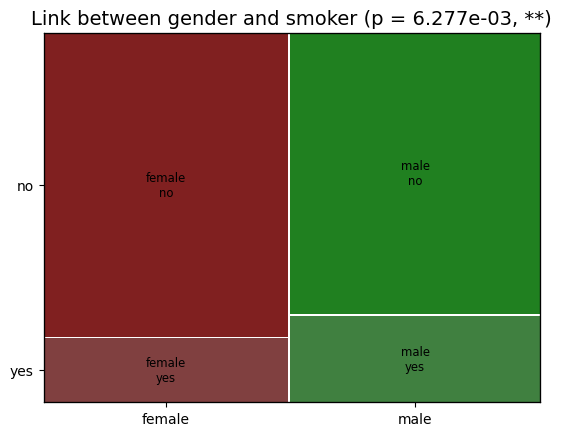

In [57]:
from statsmodels.graphics.mosaicplot import mosaic
p_value=0.0062765550120107375
def format_p_value(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'ns'
significance = format_p_value(p_value)
mosaic(df, ['sex', 'smoker'])
plt.title(f"Link between gender and smoker (p = {p_value:.3e}, {significance})", fontsize=14)

plt.show()

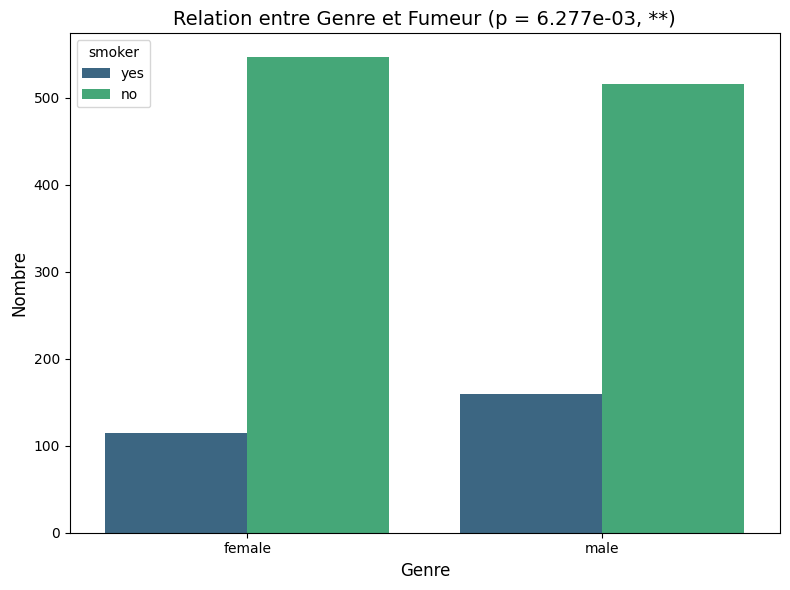

In [58]:
# Visualisation
p_value=0.0062765550120107375
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='sex', hue='smoker', palette='viridis')
def format_p_value(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'ns'
significance = format_p_value(p_value)

plt.title(f"Relation entre Genre et Fumeur (p = {p_value:.3e}, {significance})", fontsize=14)
plt.xlabel("Genre", fontsize=12)
plt.ylabel("Nombre", fontsize=12)

# Ajuster l'affichage
plt.tight_layout()
plt.show()

Women seem to smoke less than men

In [59]:
#Test for 'region' and 'smoker'
table_RSm = pd.crosstab(df['region'], df['smoker'])
chi2, p, dof, expected = chi2_contingency(table_RSm)
print(f"Chi² : {chi2}, p-value : {p}, Degrees of Freedom : {dof}")
print(f"Expected numbers : \n{expected}")

Chi² : 7.27790254132191, p-value : 0.06354826573182334, Degrees of Freedom : 3
Expected numbers : 
[[257.60059835  66.39940165]
 [257.60059835  66.39940165]
 [289.40314136  74.59685864]
 [258.39566193  66.60433807]]


<Axes: xlabel='smoker', ylabel='region'>

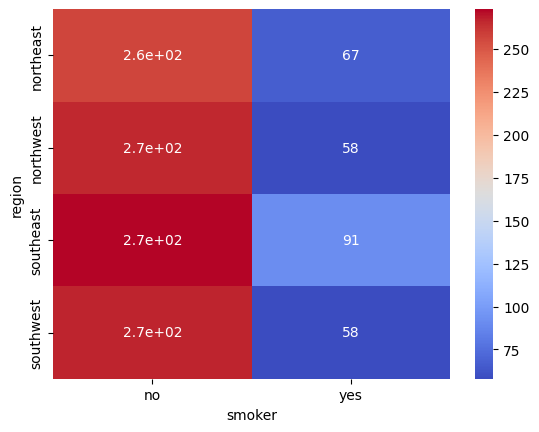

In [60]:
sns.heatmap(table_RSm, annot=True, cmap='coolwarm')

It seems that there is a light difference between the different regions, but the Chi² is not significant.

#### Test Anova to see relation between categorical variables and continuous variables

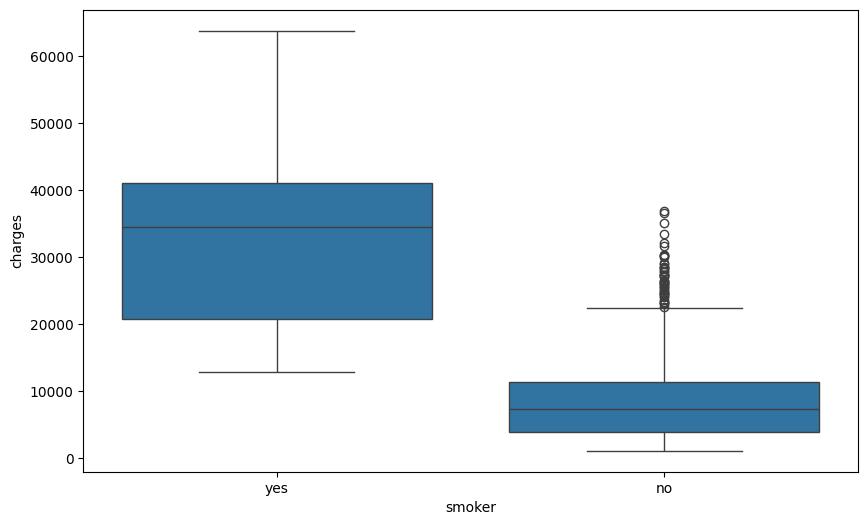

In [61]:
#Study of test and charges
plt.subplots(figsize=(10,6))
ax = sns.boxplot(y="charges", x="smoker", data=df)

Smokers pay more charges than non-smokers

In [62]:
model = ols('charges ~ C(smoker)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

sum_sq      df            F         PR(>F)
C(smoker)  1.214307e+11     1.0  2175.736863  1.406722e-282
Residual   7.450811e+10  1335.0          NaN            NaN

In [63]:
def anova_test(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']

    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])

    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])

    cols = ['sum_sq', 'df', 'mean_sq', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

anova_test(anova_table)

/tmp/ipykernel_594066/1891193163.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])


sum_sq      df       mean_sq            F         PR(>F)  \
C(smoker)  1.214307e+11     1.0  1.214307e+11  2175.736863  1.406722e-282   
Residual   7.450811e+10  1335.0  5.581132e+07          NaN            NaN   

             eta_sq  omega_sq  
C(smoker)  0.619738  0.619277  
Residual        NaN       NaN

In [64]:
for i in columns:
    for j in columns_cat:
        model = ols(f'{i}~ C({j})', data=df).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        print(f"anova for {i}")
        print(anova_table)
        print(anova_test(anova_table))

anova for charges
                sum_sq      df         F    PR(>F)
C(sex)    6.601500e+08     1.0  4.513038  0.033821
Residual  1.952787e+11  1335.0       NaN       NaN
                sum_sq      df       mean_sq         F    PR(>F)    eta_sq  \
C(sex)    6.601500e+08     1.0  6.601500e+08  4.513038  0.033821  0.003369   
Residual  1.952787e+11  1335.0  1.462762e+08       NaN       NaN       NaN   

          omega_sq  
C(sex)    0.002621  
Residual       NaN  
anova for charges
                 sum_sq      df            F         PR(>F)
C(smoker)  1.214307e+11     1.0  2175.736863  1.406722e-282
Residual   7.450811e+10  1335.0          NaN            NaN
                 sum_sq      df       mean_sq            F         PR(>F)  \
C(smoker)  1.214307e+11     1.0  1.214307e+11  2175.736863  1.406722e-282   
Residual   7.450811e+10  1335.0  5.581132e+07          NaN            NaN   

             eta_sq  omega_sq  
C(smoker)  0.619738  0.619277  
Residual        NaN       NaN  
anova

/tmp/ipykernel_594066/1891193163.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
/tmp/ipykernel_594066/1891193163.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
/tmp/ipykernel_594066/1891193163.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To a

This test confirms relation between charges, smokers and bmi. Stunnishly, it seems to be a link between region and bmi!

/tmp/ipykernel_594066/1953280015.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.barplot(data=df, x="region", y="bmi", palette='pastel')


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

southeast vs. northeast: t-test independent samples, P_val:1.186e-17 t=8.791e+00
southwest vs. northwest: t-test independent samples, P_val:1.058e-03 t=3.290e+00


(<Axes: xlabel='region', ylabel='bmi'>,
  <statannotations.Annotation.Annotation at 0x7553f145ffe0>])

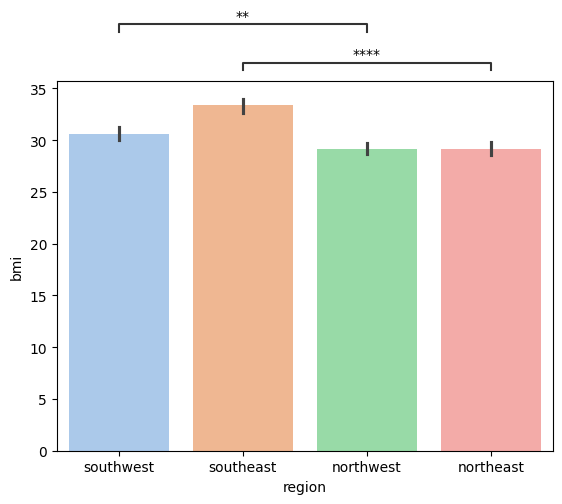

In [65]:
#Test annotation
ax=sns.barplot(data=df, x="region", y="bmi", palette='pastel')
pairs = [("northeast", "southeast"), ("northwest", "southwest")]
annotator = Annotator(ax, pairs, data=df, x="region", y="bmi")
annotator.configure(test='t-test_ind', text_format='star', loc='outside')
annotator.apply_and_annotate()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

southwest vs. southeast: t-test independent samples, P_val:5.437e-09 t=-5.908e+00
southeast vs. northwest: t-test independent samples, P_val:2.750e-19 t=9.252e+00
southeast vs. northeast: t-test independent samples, P_val:1.186e-17 t=8.791e+00


/tmp/ipykernel_594066/1746113485.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.barplot(data=df, x="region", y="bmi", palette='pastel')


(<Axes: xlabel='region', ylabel='bmi'>,
  <statannotations.Annotation.Annotation at 0x7553f14c5970>])

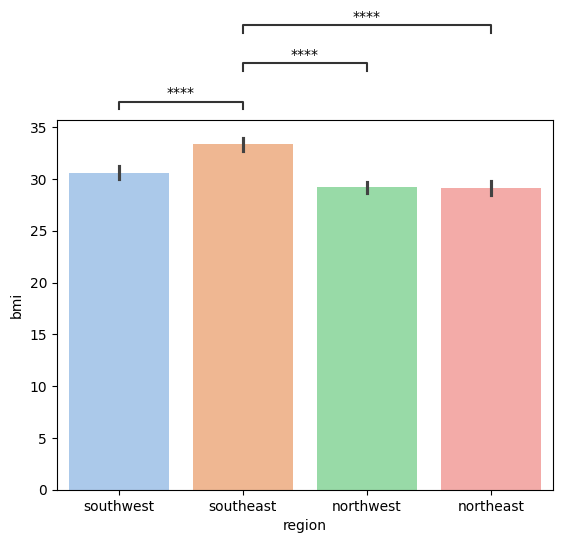

In [66]:
#comparaison southeast par rapport aux autres

ax=sns.barplot(data=df, x="region", y="bmi", palette='pastel')
target = "southeast"
pairs = [(target, region) for region in df['region'].unique() if region != target]
annotator = Annotator(ax, pairs, data=df, x="region", y="bmi")
annotator.configure(test='t-test_ind', text_format='star', loc='outside')
annotator.apply_and_annotate()#comparaison southeast par rapport aux autres
 

Individuals from southeast region are bigger and/or smaller than indiviudals from other regions.

In [67]:
#visualisation des p_values

## source : https://asardell.github.io/statistique-python/
#source sur une ancienne version de python, .set_precision remplacé par .format(precision=2)


n=len(columns)
m=len(columns_cat)

#Creation of an empty matrix
a=np.empty((m,n))
a[:] = np.nan

for j in range(n):
    for i in range(m):
        model = ols(f'{columns[j]}~ C({columns_cat[i]})', data=df).fit()
        anova_table=sm.stats.anova_lm(model, typ=2)
        p_value=anova_table.iloc[0,-1]
        a[i,j] = p_value

df_pvalue = round(pd.DataFrame(a, columns=columns, index = columns_cat),5)

cm = sns.light_palette("green", as_cmap=True) 

df_pvalue.style.background_gradient(cmap=cm).format(precision=2)

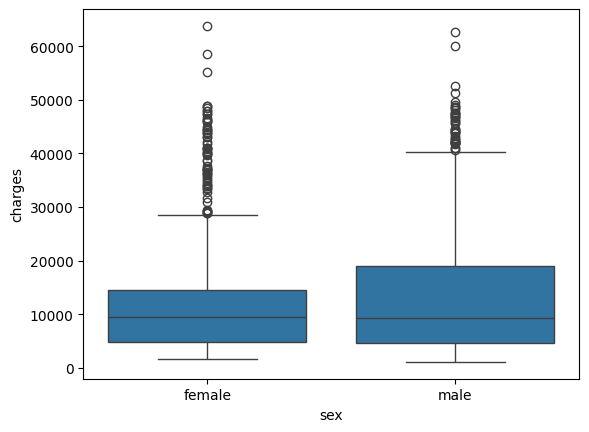

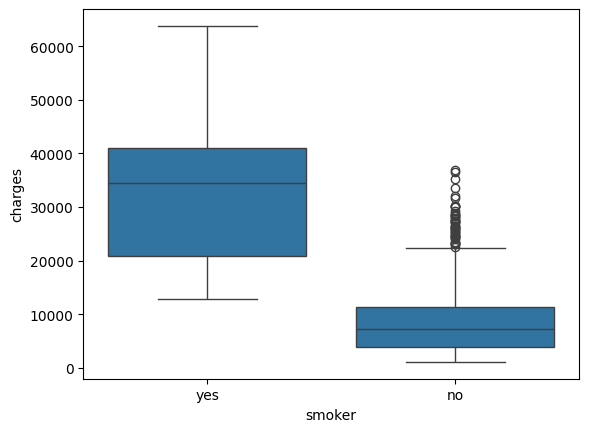

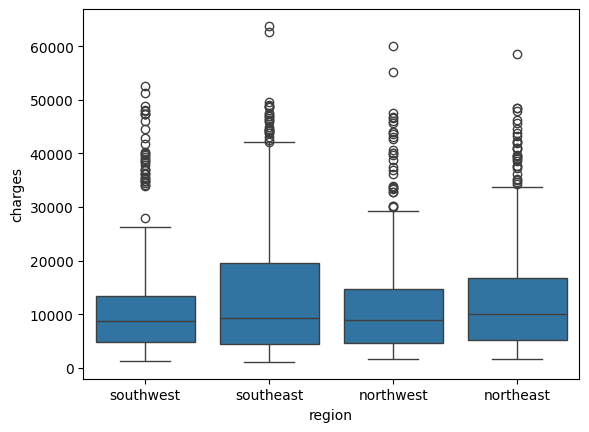

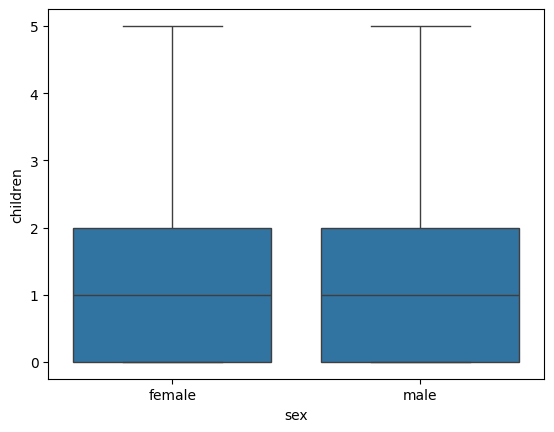

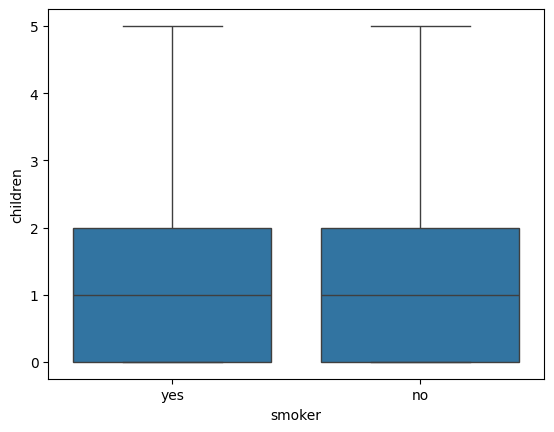

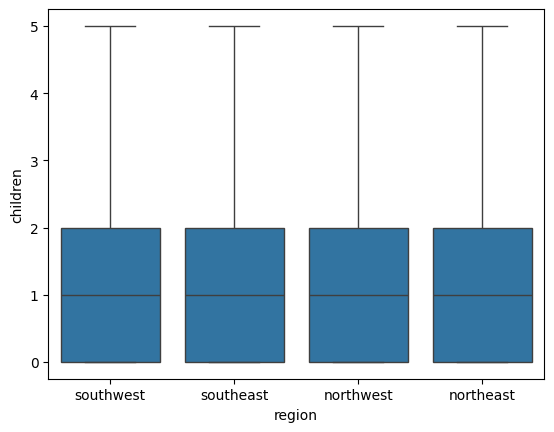

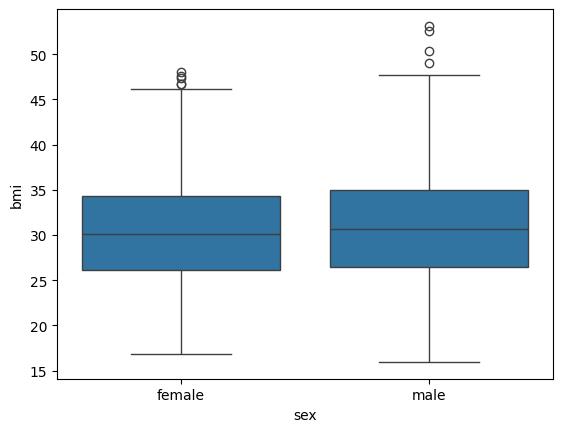

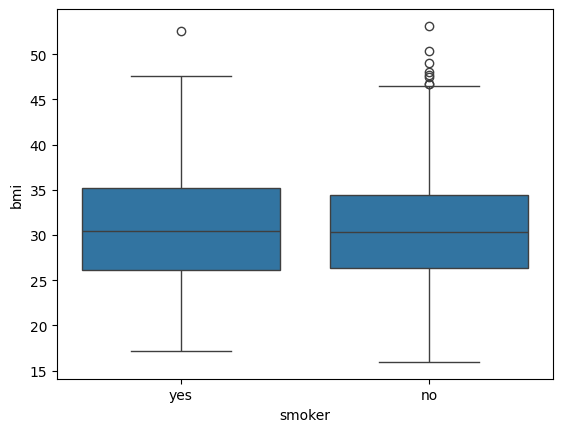

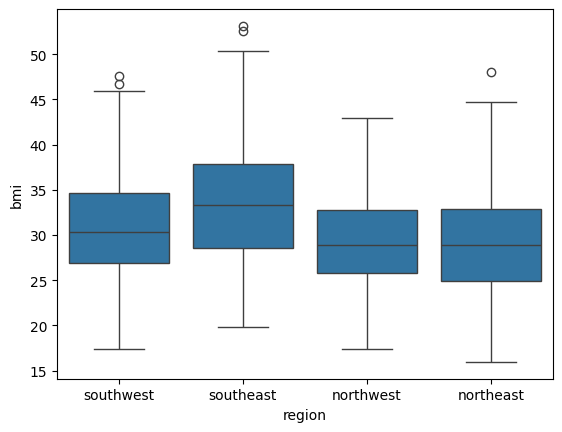

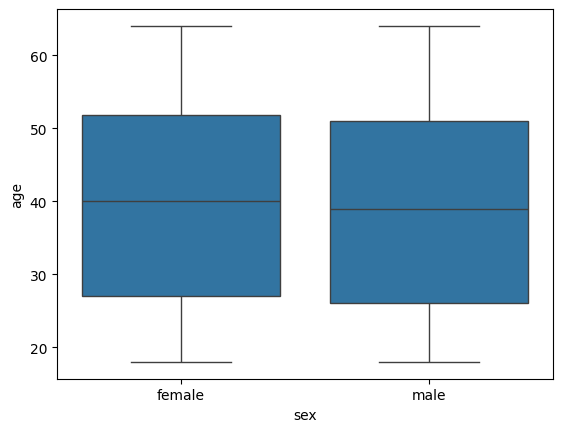

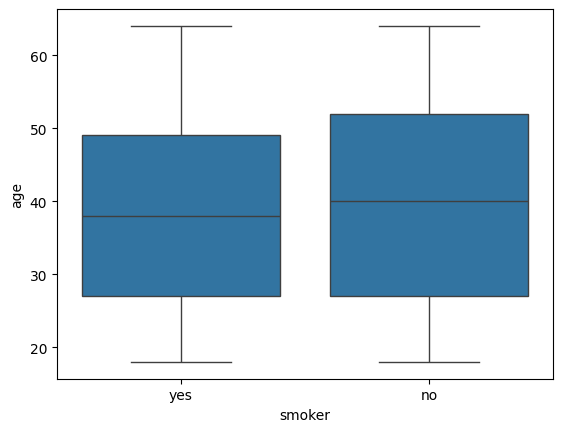

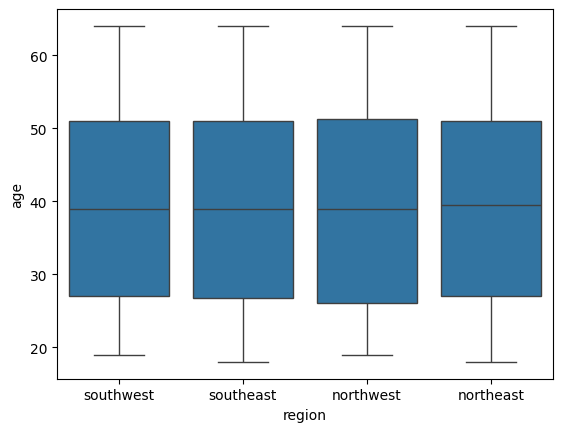

In [68]:
#Visualization of relations between continuous and categorical variables
for continue_data in columns:
    for discrete_data in columns_cat:
        sns.boxplot(y=continue_data, x=discrete_data, data=df)
        plt.show()


#### Pearson test to see correlations between continuous variables

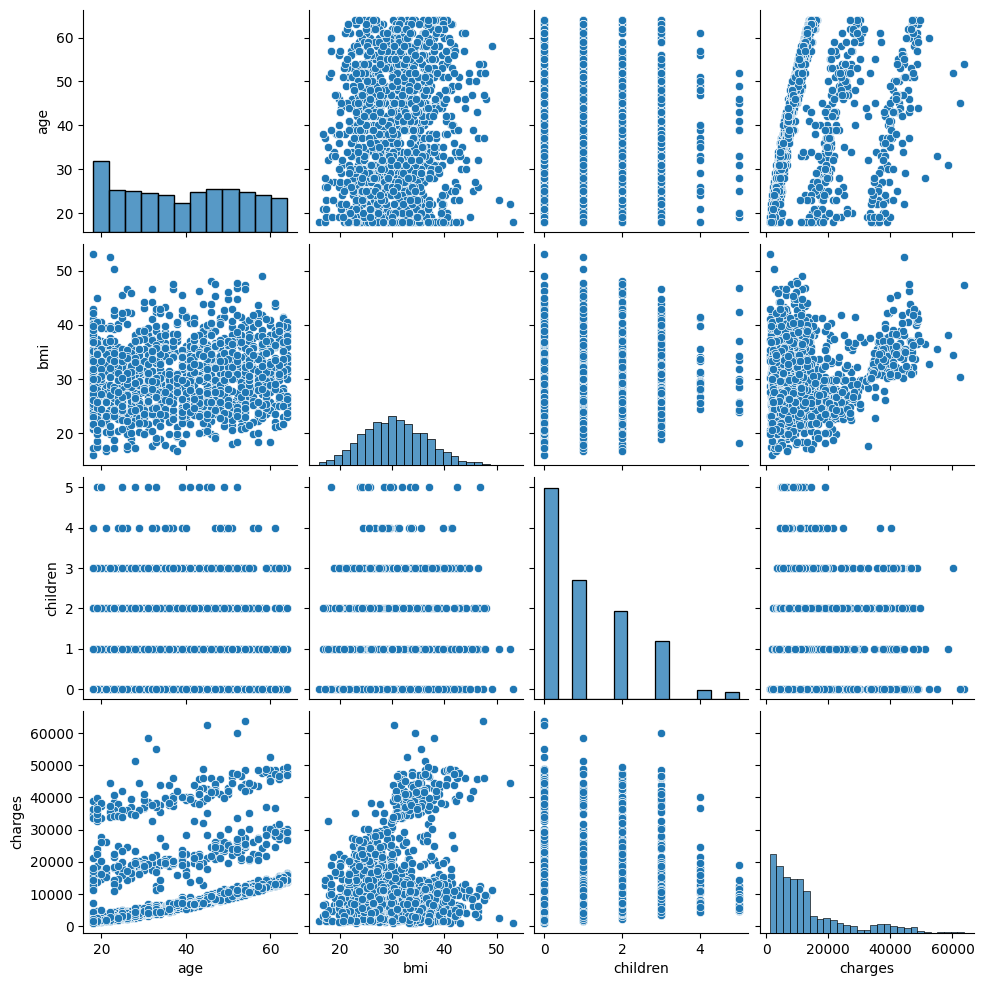

In [69]:
sns.pairplot(df)

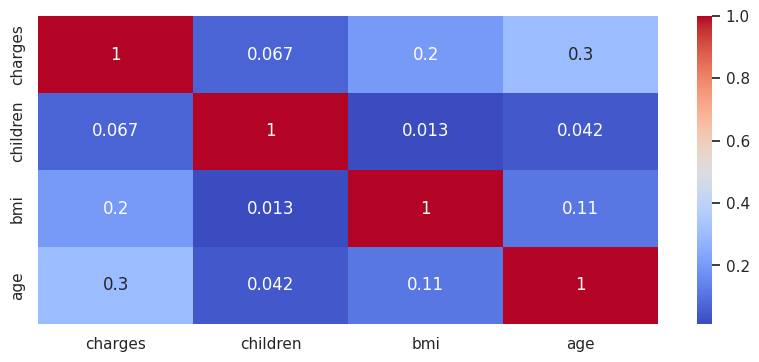

In [70]:
# Correlation matrix
sns.set(rc={'figure.figsize':(10,4)})
df_corr=df[columns].corr()
ax=sns.heatmap(df_corr, annot=True, cmap='coolwarm')

Even if results are not obvious, it tends to show a relation  between bmi, age and charges

In [71]:
#Bmi vs charges
pearsonr(df.charges, df.bmi)

PearsonRResult(statistic=np.float64(0.19840083122624935), pvalue=np.float64(2.4680404264513685e-13))

There is a correlation between these two variables

In [72]:
#Test for values 1vs1 
for i in columns:
    for j in columns:
       print(pearsonr(df[i], df[j]))
       

PearsonRResult(statistic=np.float64(1.0), pvalue=np.float64(0.0))
PearsonRResult(statistic=np.float64(0.06738935083963249), pvalue=np.float64(0.013717026292987116))
PearsonRResult(statistic=np.float64(0.19840083122624935), pvalue=np.float64(2.4680404264513685e-13))
PearsonRResult(statistic=np.float64(0.29830821250978645), pvalue=np.float64(6.975748762691051e-29))
PearsonRResult(statistic=np.float64(0.06738935083963249), pvalue=np.float64(0.013717026292987116))
PearsonRResult(statistic=np.float64(1.0), pvalue=np.float64(0.0))
PearsonRResult(statistic=np.float64(0.012754657513395232), pvalue=np.float64(0.6412463331651338))
PearsonRResult(statistic=np.float64(0.04153621001636623), pvalue=np.float64(0.12901275682640062))
PearsonRResult(statistic=np.float64(0.19840083122624935), pvalue=np.float64(2.4680404264513685e-13))
PearsonRResult(statistic=np.float64(0.012754657513395235), pvalue=np.float64(0.6412463331651338))
PearsonRResult(statistic=np.float64(0.9999999999999999), pvalue=np.float64

In [73]:
## source : https://asardell.github.io/statistique-python/
#source sur une ancienne version de python, .set_precision remplacé par .format(precision=2)

n=len(columns)

#Empty matrix
a=np.empty((n,n))
a[:] = np.nan

#fulfill matrix with correlations matrix
for i in range(n):
    for j in range(n):
        coeff, p_value = pearsonr(df[columns[i]], df[columns[j]])
        print(f"Correlation entre {columns[i]} et {columns[j]}: coeff={coeff}, p={p_value}")
        a[i,j] = p_value
df_pvalue = round(pd.DataFrame(a, columns=columns, index = columns),5)

cm = sns.light_palette("green", as_cmap=True) 

df_pvalue.style.background_gradient(cmap=cm).format(precision=2)

Correlation entre charges et charges: coeff=1.0, p=0.0
Correlation entre charges et children: coeff=0.06738935083963249, p=0.013717026292987116
Correlation entre charges et bmi: coeff=0.19840083122624935, p=2.4680404264513685e-13
Correlation entre charges et age: coeff=0.29830821250978645, p=6.975748762691051e-29
Correlation entre children et charges: coeff=0.06738935083963249, p=0.013717026292987116
Correlation entre children et children: coeff=1.0, p=0.0
Correlation entre children et bmi: coeff=0.012754657513395232, p=0.6412463331651338
Correlation entre children et age: coeff=0.04153621001636623, p=0.12901275682640062
Correlation entre bmi et charges: coeff=0.19840083122624935, p=2.4680404264513685e-13
Correlation entre bmi et children: coeff=0.012754657513395235, p=0.6412463331651338
Correlation entre bmi et bmi: coeff=0.9999999999999999, p=0.0
Correlation entre bmi et age: coeff=0.10934361041896884, p=6.164372237148674e-05
Correlation entre age et charges: coeff=0.2983082125097864

Correlation betweeen bmi, age and charges. In an other way, number of child seems to not be an important value.

In [74]:
# log(1+p)
n=len(columns)

a=np.empty((n,n))
a[:] = np.nan
df_log_1p = df[columns].apply(lambda x: np.log1p(x))
df_log_1p

for i in range(n):
    for j in range(n):
        coeff, p_value = pearsonr(df_log_1p[columns[i]], df_log_1p[columns[j]])
        print(f"Correlation entre {columns[i]} et {columns[j]}: coeff={coeff}, p={p_value}")
        a[i,j] = p_value
dflog_1p_pvalue = round(pd.DataFrame(a, columns=columns, index = columns),5)

cm = sns.light_palette("green", as_cmap=True) 

dflog_1p_pvalue.style.background_gradient(cmap=cm).format(precision=2)

Correlation entre charges et charges: coeff=1.0, p=0.0
Correlation entre charges et children: coeff=0.17061005370248125, p=3.4161432329132476e-10
Correlation entre charges et bmi: coeff=0.13809470491918724, p=3.998786709637184e-07
Correlation entre charges et age: coeff=0.5339456976832563, p=2.090998758332476e-99
Correlation entre children et charges: coeff=0.17061005370248128, p=3.4161432329132476e-10
Correlation entre children et children: coeff=0.9999999999999998, p=0.0
Correlation entre children et bmi: coeff=0.015898032145634074, p=0.5613720877157167
Correlation entre children et age: coeff=0.10048018988891569, p=0.00023328953131462142
Correlation entre bmi et charges: coeff=0.13809470491918724, p=3.998786709637184e-07
Correlation entre bmi et children: coeff=0.01589803214563407, p=0.5613720877157167
Correlation entre bmi et bmi: coeff=0.9999999999999999, p=0.0
Correlation entre bmi et age: coeff=0.10967823305699058, p=5.8504259321896036e-05
Correlation entre age et charges: coeff

Differences are bigger , no ?

# Visualizations

<Axes: title={'center': 'Charges per age'}, xlabel='age', ylabel='charges'>

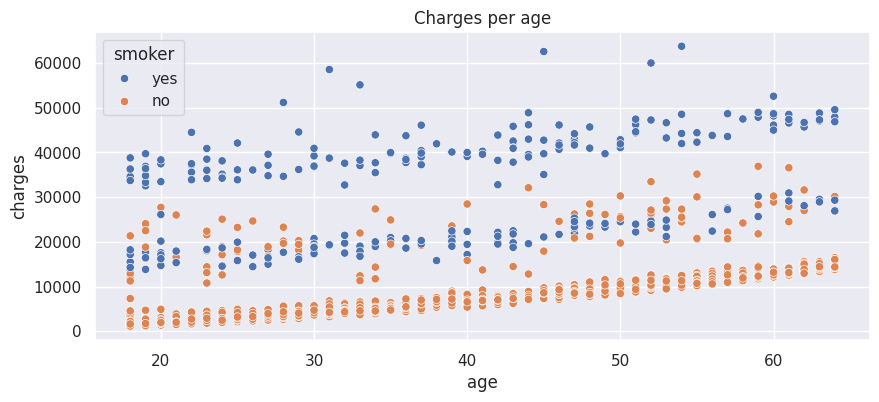

In [75]:
plt.title('Charges per age')
sns.scatterplot(x=df.age, y=df.charges, hue=df.smoker)

<Axes: title={'center': 'Charges per bmi'}, xlabel='bmi', ylabel='charges'>

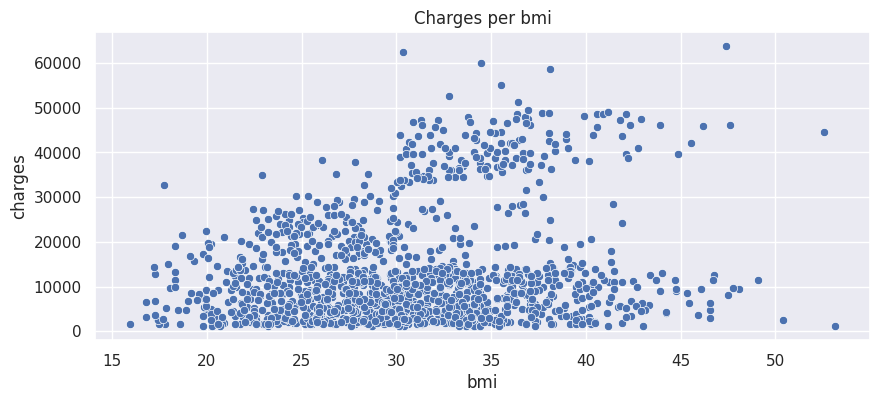

In [76]:
plt.title('Charges per bmi')
sns.scatterplot(x=df.bmi, y=df.charges)

<Axes: title={'center': 'Charges per bmi'}, xlabel='bmi', ylabel='charges'>

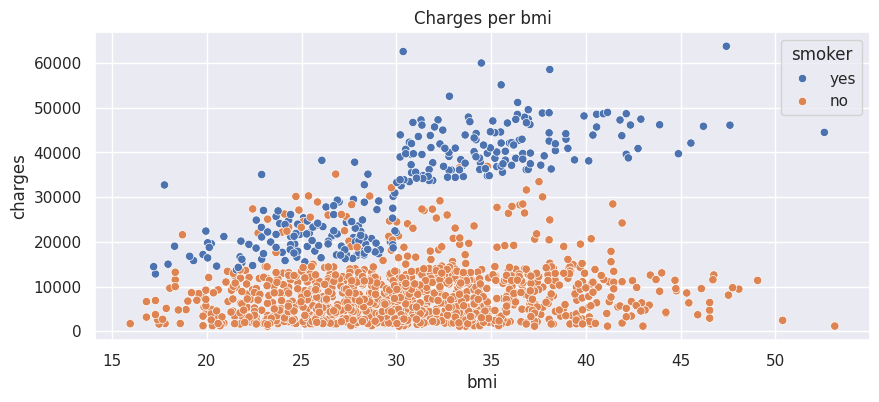

In [77]:
plt.title('Charges per bmi')
sns.scatterplot(x='bmi', y='charges', data=df, hue='smoker')

The scatterplots charges/bmi with hue=smoker allows us to understand this pattern. Charges raises with bmi only for smokers.

/tmp/ipykernel_594066/1236225600.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df.smoker, y=df.charges, palette='flare')


<Axes: title={'center': 'Charges for smokers and non-smokers'}, xlabel='smoker', ylabel='charges'>

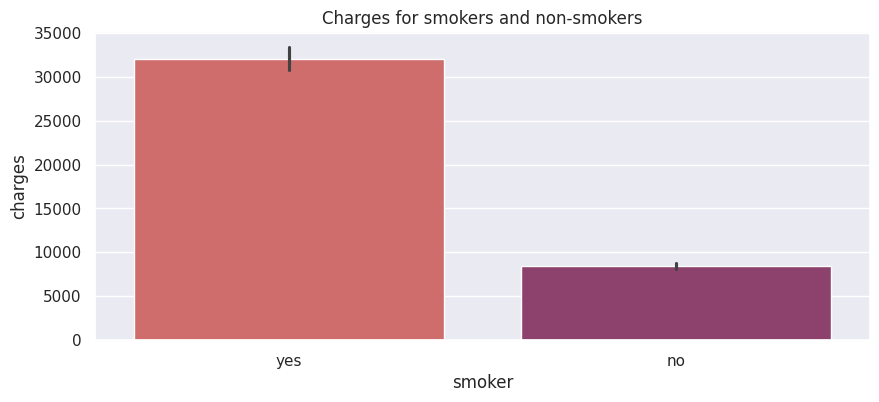

In [78]:
plt.title('Charges for smokers and non-smokers')
sns.barplot(x=df.smoker, y=df.charges, palette='flare')

/tmp/ipykernel_594066/508977280.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df.sex, y=df.charges, palette='pastel')


<Axes: title={'center': 'Charges for females and males'}, xlabel='sex', ylabel='charges'>

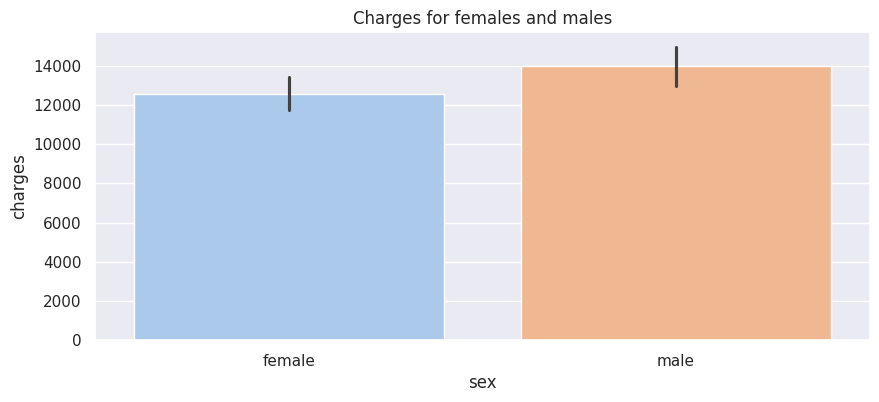

In [79]:
plt.title('Charges for females and males')
sns.barplot(x=df.sex, y=df.charges, palette='pastel')

/tmp/ipykernel_594066/3664918362.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df.sex, y=df.bmi, palette='pastel')


<Axes: title={'center': 'Charges for females and males'}, xlabel='sex', ylabel='bmi'>

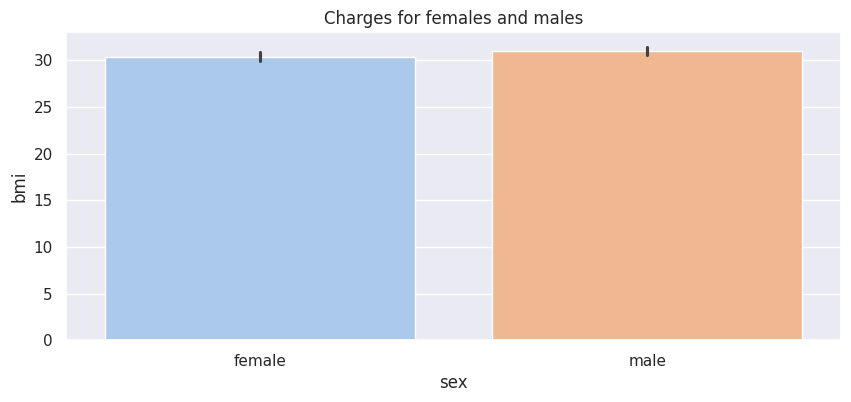

In [80]:
plt.title('Charges for females and males')
sns.barplot(x=df.sex, y=df.bmi, palette='pastel')

In [81]:
df=pd.read_csv('cleansed_data.csv')

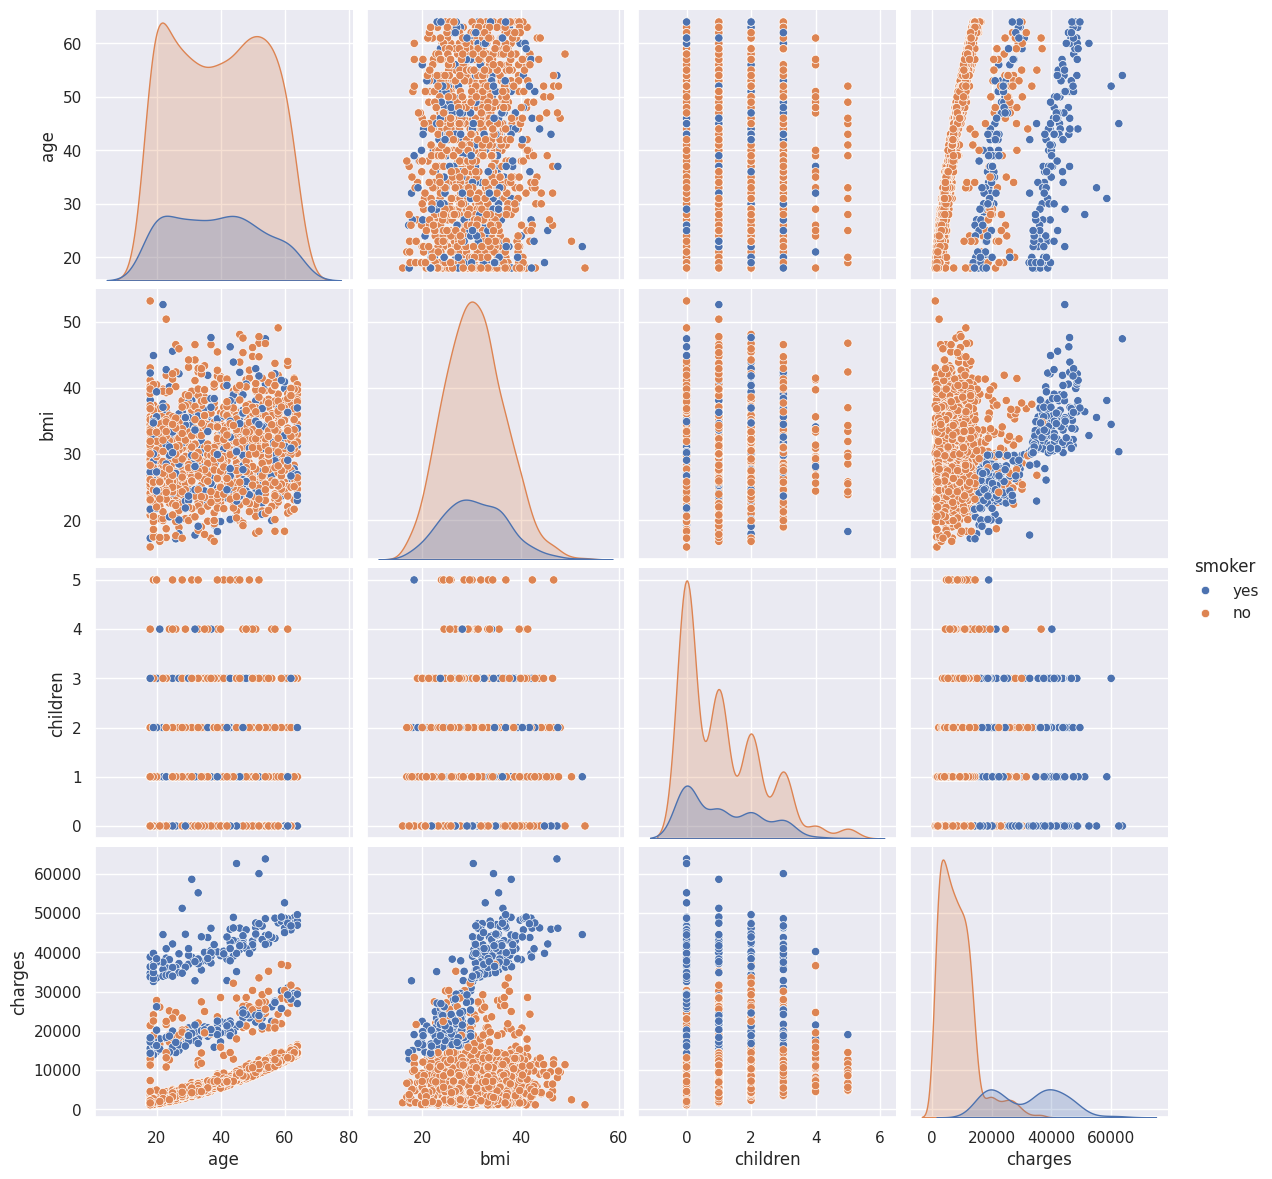

In [82]:
sns.pairplot(df, hue="smoker", height=3)

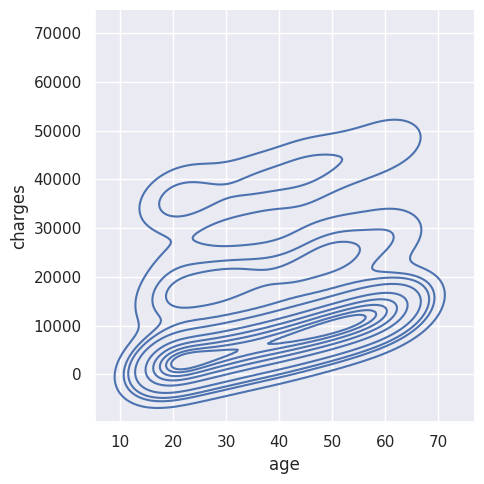

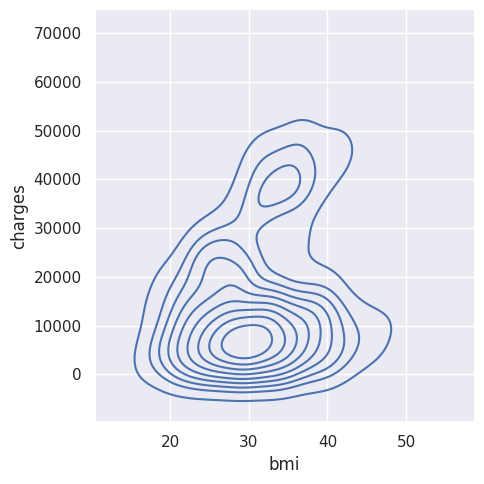

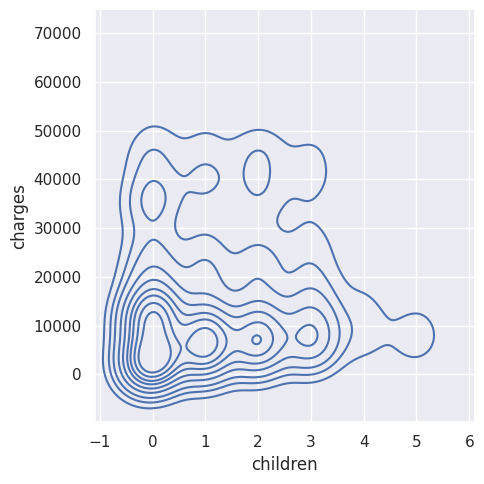

In [83]:
#Bivariate analysis
sns.displot(df, x="age", y="charges", kind="kde")
sns.displot(df, x="bmi", y="charges", kind="kde")
sns.displot(df, x="children", y="charges", kind="kde")

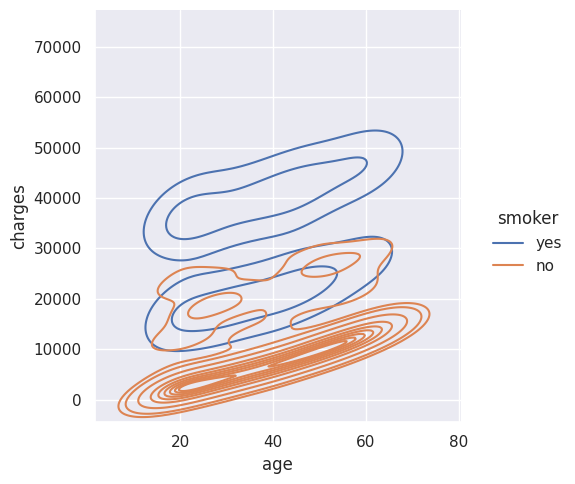

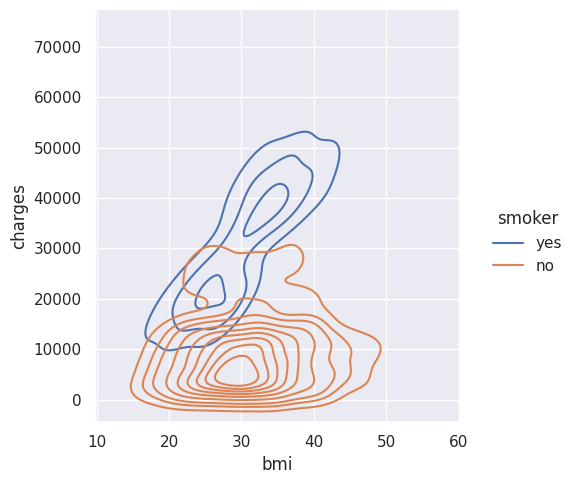

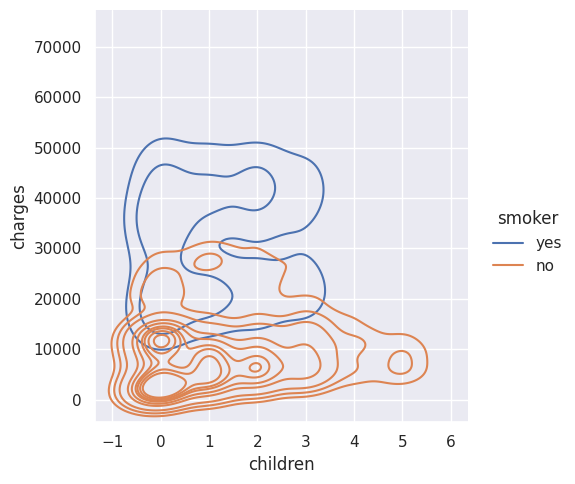

In [84]:
#Bivariate analysis for smoker and no smokers
sns.displot(df, x="age", y="charges", kind="kde", hue="smoker")
sns.displot(df, x="bmi", y="charges", kind="kde", hue="smoker")
sns.displot(df, x="children", y="charges", kind="kde", hue="smoker")

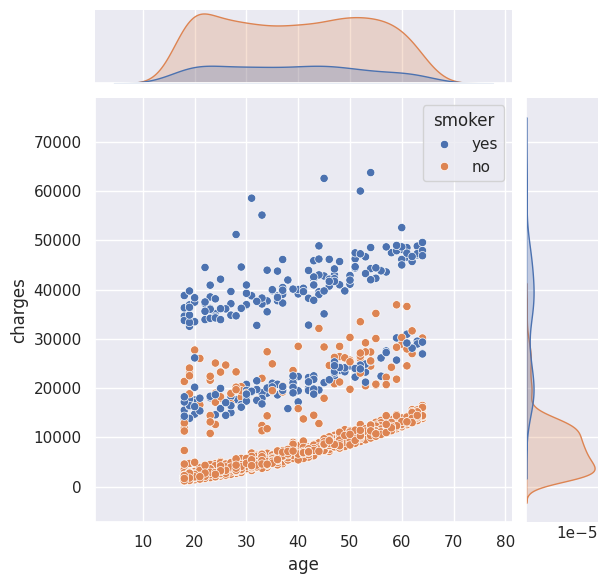

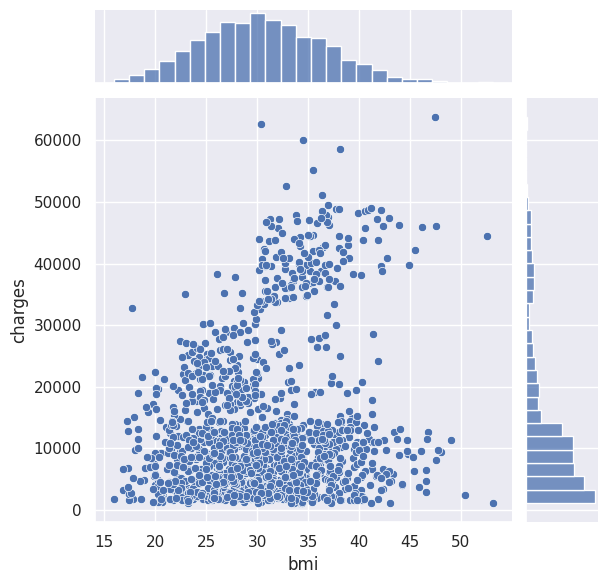

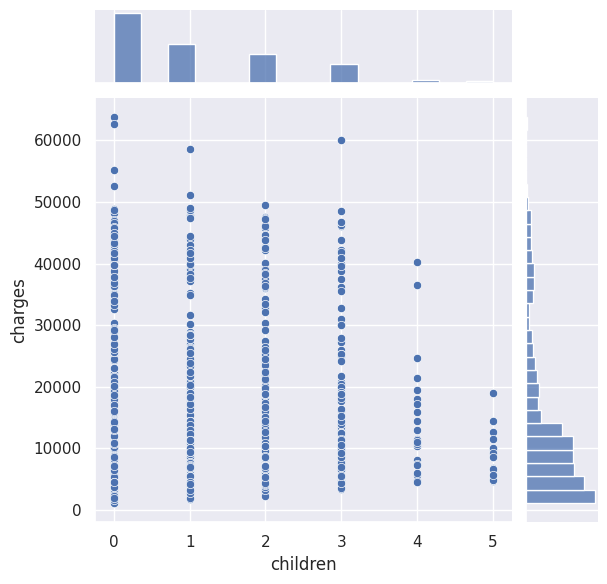

In [85]:
#plotting joint and marginal distributions
sns.jointplot(data=df, x="age", y="charges", hue="smoker")
sns.jointplot(data=df, x="bmi", y="charges")
sns.jointplot(data=df, x="children", y="charges")

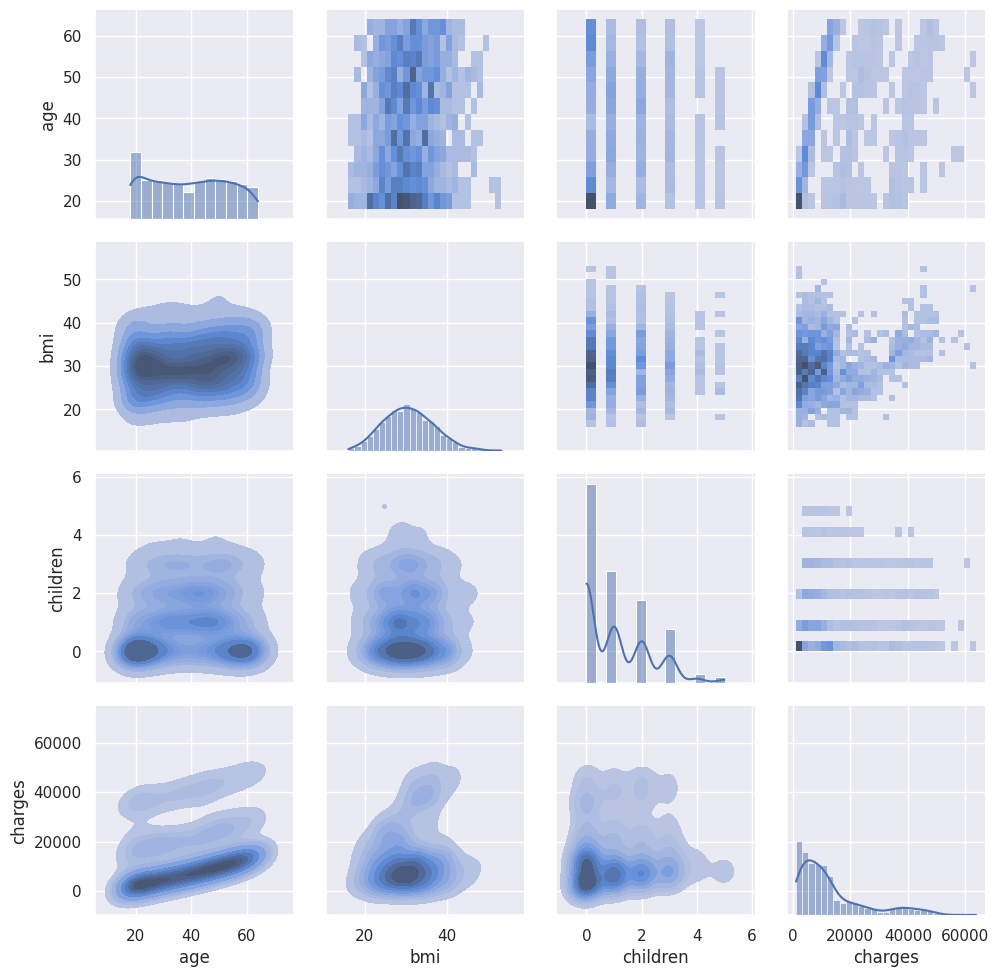

In [86]:
g=sns.PairGrid(df)
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True)

## Split of Bmi in category

## Use of Violin Plot

In [87]:
bins = [0, 29.999, 100]  # Tranches de BMI
labels = ['Normal weight', 'Obesity']

#Add a new column in DF for bmi bins
df["bmi_category"] = pd.cut(df['bmi'], bins=bins, labels=labels, right=False)
df

age     sex     bmi  children smoker     region      charges  \
0      19  female  27.900         0    yes  southwest  16884.92400   
1      18    male  33.770         1     no  southeast   1725.55230   
2      28    male  33.000         3     no  southeast   4449.46200   
3      33    male  22.705         0     no  northwest  21984.47061   
4      32    male  28.880         0     no  northwest   3866.85520   
...   ...     ...     ...       ...    ...        ...          ...   
1332   50    male  30.970         3     no  northwest  10600.54830   
1333   18  female  31.920         0     no  northeast   2205.98080   
1334   18  female  36.850         0     no  southeast   1629.83350   
1335   21  female  25.800         0     no  southwest   2007.94500   
1336   61  female  29.070         0    yes  northwest  29141.36030   

       bmi_category  
0     Normal weight  
1           Obesity  
2           Obesity  
3     Normal weight  
4     Normal weight  
...             ...  
1332        Obesity  
1333        Obesity  
1334        Obesity  
1335  Normal weight  
1336  Normal weight  

[1337 rows x 8 columns]

<Axes: xlabel='bmi_category', ylabel='charges'>

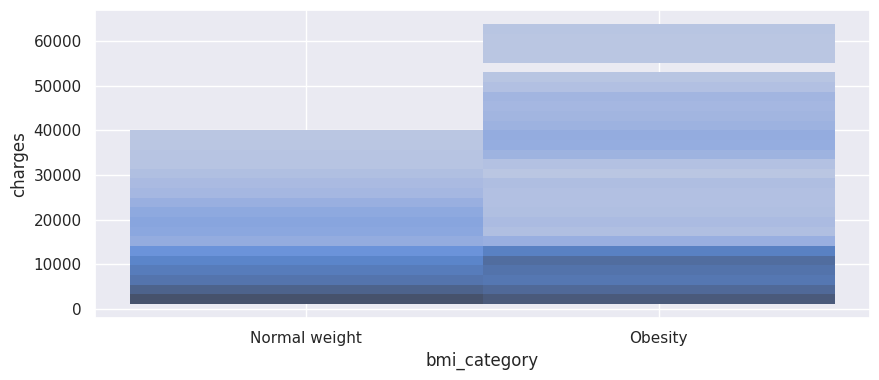

In [88]:
sns.histplot(y=df.charges, x=df.bmi_category)

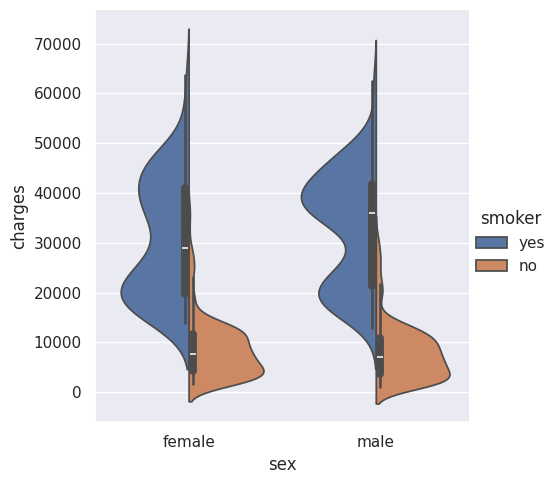

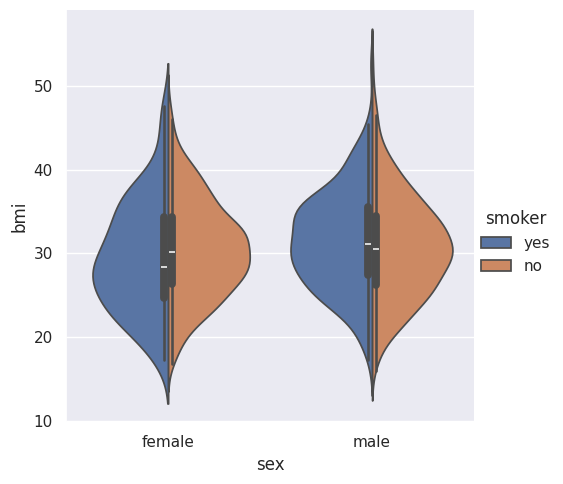

In [89]:
sns.catplot(data=df, x="sex", y="charges", hue="smoker", kind="violin", split=True)
sns.catplot(data=df, x="sex", y="bmi", hue="smoker", kind="violin", split=True)

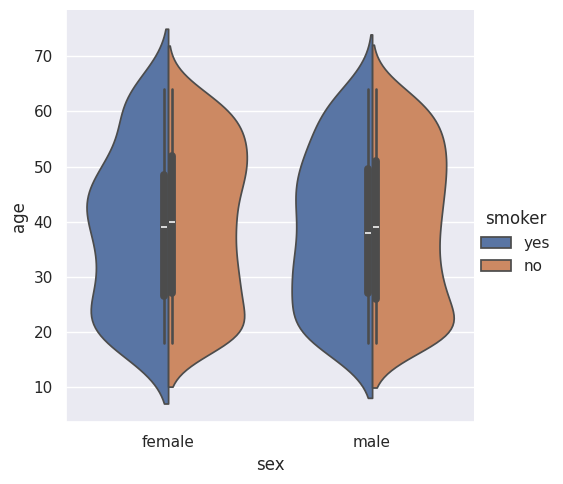

In [90]:
sns.catplot(data=df, x="sex", y="age", hue="smoker", kind="violin", split=True)

In [ ]:
# Nuage de points avec ligne de régression
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='charges', hue='smoker', data=df, palette='Set1')

# Ajout de la ligne de régression
sns.regplot(x='age', y='charges', data=df, scatter=False, color='black')

# Ajout de titres
plt.title('Charges per Age with Regression Line', fontsize=14)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Charges', fontsize=12)
plt.legend(title='Smoker')
plt

## Test with a regression line

<module 'matplotlib.pyplot' from '/home/ludivine/Documents/prime_assurance/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

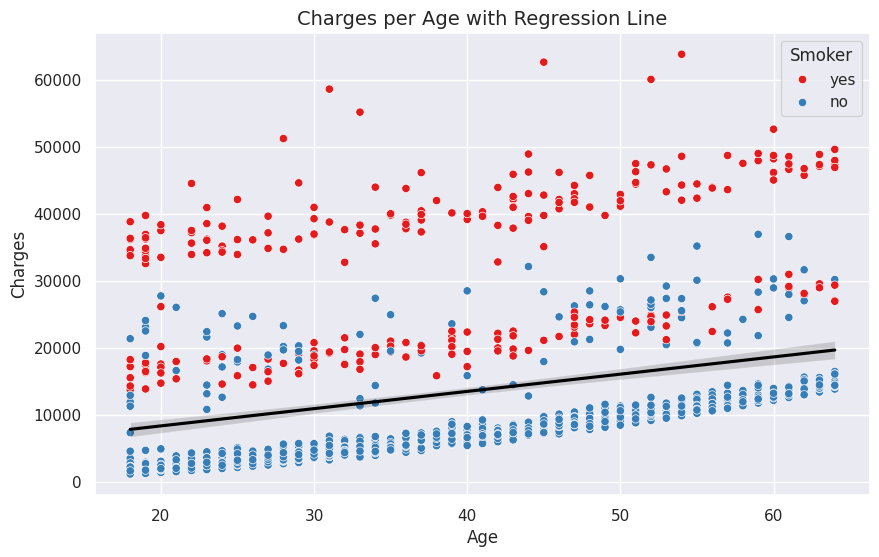

In [92]:
# Nuage de points avec ligne de régression
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='charges', hue='smoker', data=df, palette='Set1')

# Ajout de la ligne de régression
sns.regplot(x='age', y='charges', data=df, scatter=False, color='black')

# Ajout de titres
plt.title('Charges per Age with Regression Line', fontsize=14)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Charges', fontsize=12)
plt.legend(title='Smoker')
plt
